In [113]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import bambi as bmb 
import hssm
import os
import arviz as az 
import pymc as pm 
hssm.set_floatX("float32")
random_seed = 10

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


## Read data

In [93]:
def extract_data(fname):
    # Drop rows with missing data in column: 'means'
    if fname.endswith('csv'):
        data = pd.read_csv('data/'+fname)
        if len(data) != 587:
            # print(len(data))
            return None
    else: 
        return None

    try:
        data = data.dropna(subset=['means'])
        # Filter rows based on column: 'difference'
        data = data[data['difference'].notna()]
        # Select columns: 'means', 'direction' and 8 other columns
        if data['participant'].unique()[0]%3 == 0:
            data['key_resp'] = data['slider_resp_recorded_keyresp.keys']
            data['rt'] = data['slider_resp_recorded_keyresp.rt']
            data['cond'] = 'chart'
        elif data['participant'].unique()[0]%3 == 1:
            data['key_resp'] = data['numerical_choice_resp.keys']
            data['rt'] = data['numerical_choice_resp.rt']
            data['cond'] = 'slider'
        else:
            data['key_resp'] = data['slider_resp_recorded_keyresp_2.keys']
            data['rt'] = data['slider_resp_recorded_keyresp_2.rt']
            data['cond'] = 'numerical'

        data = data.loc[:, ['participant', 'means', 'direction', 'bumps', 'diff_dir', 'trials.thisN', 'difference', 'incorrect choice', 'key_resp', 'rt', 'cond']]
        data['accuracy'] = (data['incorrect choice'].values != data['key_resp'].values)
        data['response'] = -1
        data.loc[data['accuracy'], 'response'] = 1
    except:
        return None
    return data.reset_index(drop=True)

# data_clean = extract_data(data.copy())
# data_clean.head()

In [94]:
files = os.listdir('data/')
comb_data = pd.concat([extract_data(fname) for fname in files]).reset_index(drop=True)


In [97]:
comb_data

,participant,means,direction,bumps,diff_dir,trials.thisN,difference,incorrect choice,key_resp,rt,cond,accuracy,response
0,25353.0,64.0,1.0,single,1.0,0.0,8.0,left,left,3.881548,chart,False,-1
1,25353.0,48.0,1.0,noisy,-1.0,1.0,-6.0,right,right,7.387671,chart,False,-1
2,25353.0,53.0,1.0,noisy,-1.0,2.0,-10.0,left,right,6.337773,chart,True,1
3,25353.0,64.0,-1.0,center,-1.0,3.0,-8.0,left,right,3.151569,chart,True,1
4,25353.0,60.0,1.0,center,1.0,4.0,8.0,left,right,5.806216,chart,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,908388.0,60.0,1.0,noisy,-1.0,285.0,-8.0,left,left,2.442362,chart,False,-1
11596,908388.0,49.0,1.0,single,-1.0,286.0,-12.0,right,left,0.798230,chart,True,1
11597,908388.0,38.0,-1.0,single,-1.0,287.0,-11.0,left,right,0.681007,chart,True,1
11598,908388.0,62.0,-1.0,center,-1.0,288.0,-12.0,right,left,0.802785,chart,True,1


In [115]:

diff_dir_nh = bmb.Model('accuracy~diff_dir', data = comb_data, family='bernoulli')
diff_dir_nh.build()
# diff_dir_nh.graph()
diff_dir_nh_samples = diff_dir_nh.fit(random_seed=random_seed)

Modeling the probability that accuracy==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, diff_dir]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'diff_dir'}>], dtype=object)

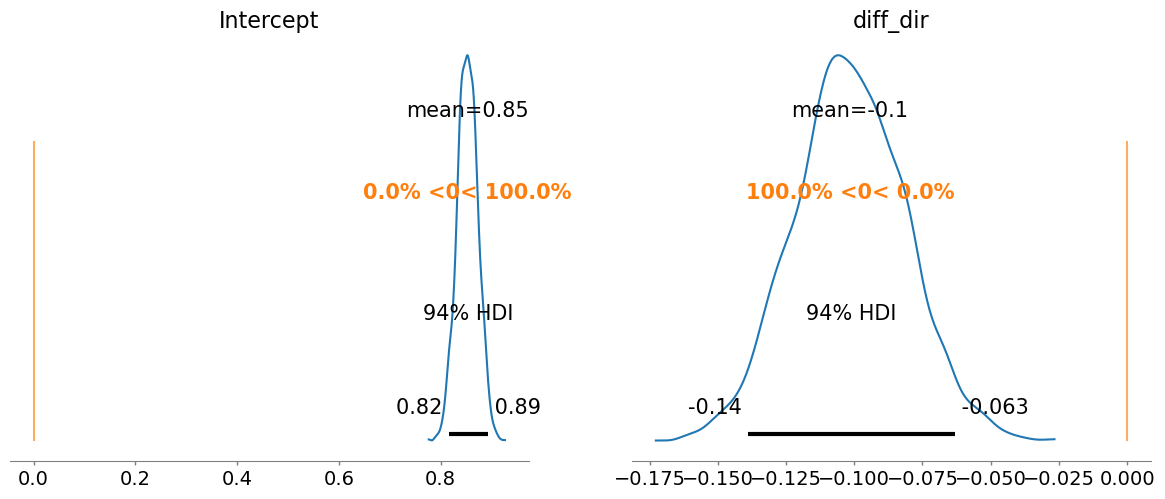

In [117]:
az.plot_posterior(diff_dir_nh_samples, ref_val = 0)

In [118]:
single_param_models = ['diff_dir', 'means', 'direction', 'bumps', 'difference', 'cond']

In [119]:
model_single_param_samples = {}
for param in single_param_models:
    print('Fittting param: ', param)
    models_oneparam_nh = bmb.Model(f'accuracy~{param}', data = comb_data, family='bernoulli')
    models_oneparam_nh.build()
    model_single_param_samples[param] = models_oneparam_nh.fit(idata_kwargs={"log_likelihood": True})
    

Modeling the probability that accuracy==1


Fittting param:  diff_dir


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, diff_dir]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
Modeling the probability that accuracy==1


Fittting param:  means


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, means]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
Modeling the probability that accuracy==1


Fittting param:  direction


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, direction]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
Modeling the probability that accuracy==1


Fittting param:  bumps


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bumps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
Modeling the probability that accuracy==1


Fittting param:  difference


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, difference]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
Modeling the probability that accuracy==1


Fittting param:  cond


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, cond]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.


In [120]:
az.compare(model_single_param_samples)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
cond,0,-6937.288150,2.952795,0.000000,9.000199e-01,44.047450,0.000000,False,log
bumps,1,-7066.464272,3.019825,129.176122,9.998014e-02,42.240365,17.808761,False,log
diff_dir,2,-7068.850616,2.063937,131.562467,1.313133e-12,42.164904,17.300612,False,log
difference,3,-7068.997193,1.913157,131.709044,1.262966e-12,42.157769,17.272602,False,log
direction,4,-7079.427111,2.075945,142.138961,2.602845e-13,41.985301,16.922277,False,log
means,5,-7080.001670,2.046399,142.713520,0.000000e+00,41.962943,16.830544,False,log


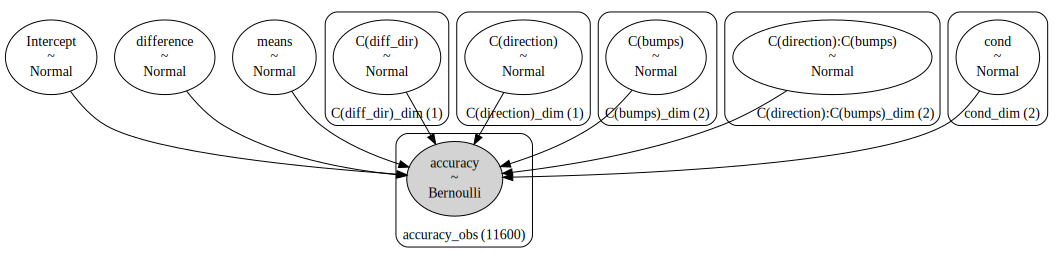

In [145]:
allparam_nh = bmb.Model('accuracy~ C(diff_dir) + means + C(direction) + C(bumps) + difference + cond', data = comb_data, family='bernoulli')
allparam_nh.build()
allparam_nh.graph()


In [143]:
allparam_nh_samples = allparam_nh.fit(idata_kwargs={"log_likelihood": True})

Modeling the probability that accuracy==1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(diff_dir), means, C(direction), C(bumps), difference, cond]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'C(diff_dir)\n1.0'}>,
        <Axes: title={'center': 'means'}>],
       [<Axes: title={'center': 'C(direction)\n1.0'}>,
        <Axes: title={'center': 'C(bumps)\nnoisy'}>,
        <Axes: title={'center': 'C(bumps)\nsingle'}>],
       [<Axes: title={'center': 'difference'}>,
        <Axes: title={'center': 'cond\nnumerical'}>,
        <Axes: title={'center': 'cond\nslider'}>]], dtype=object)

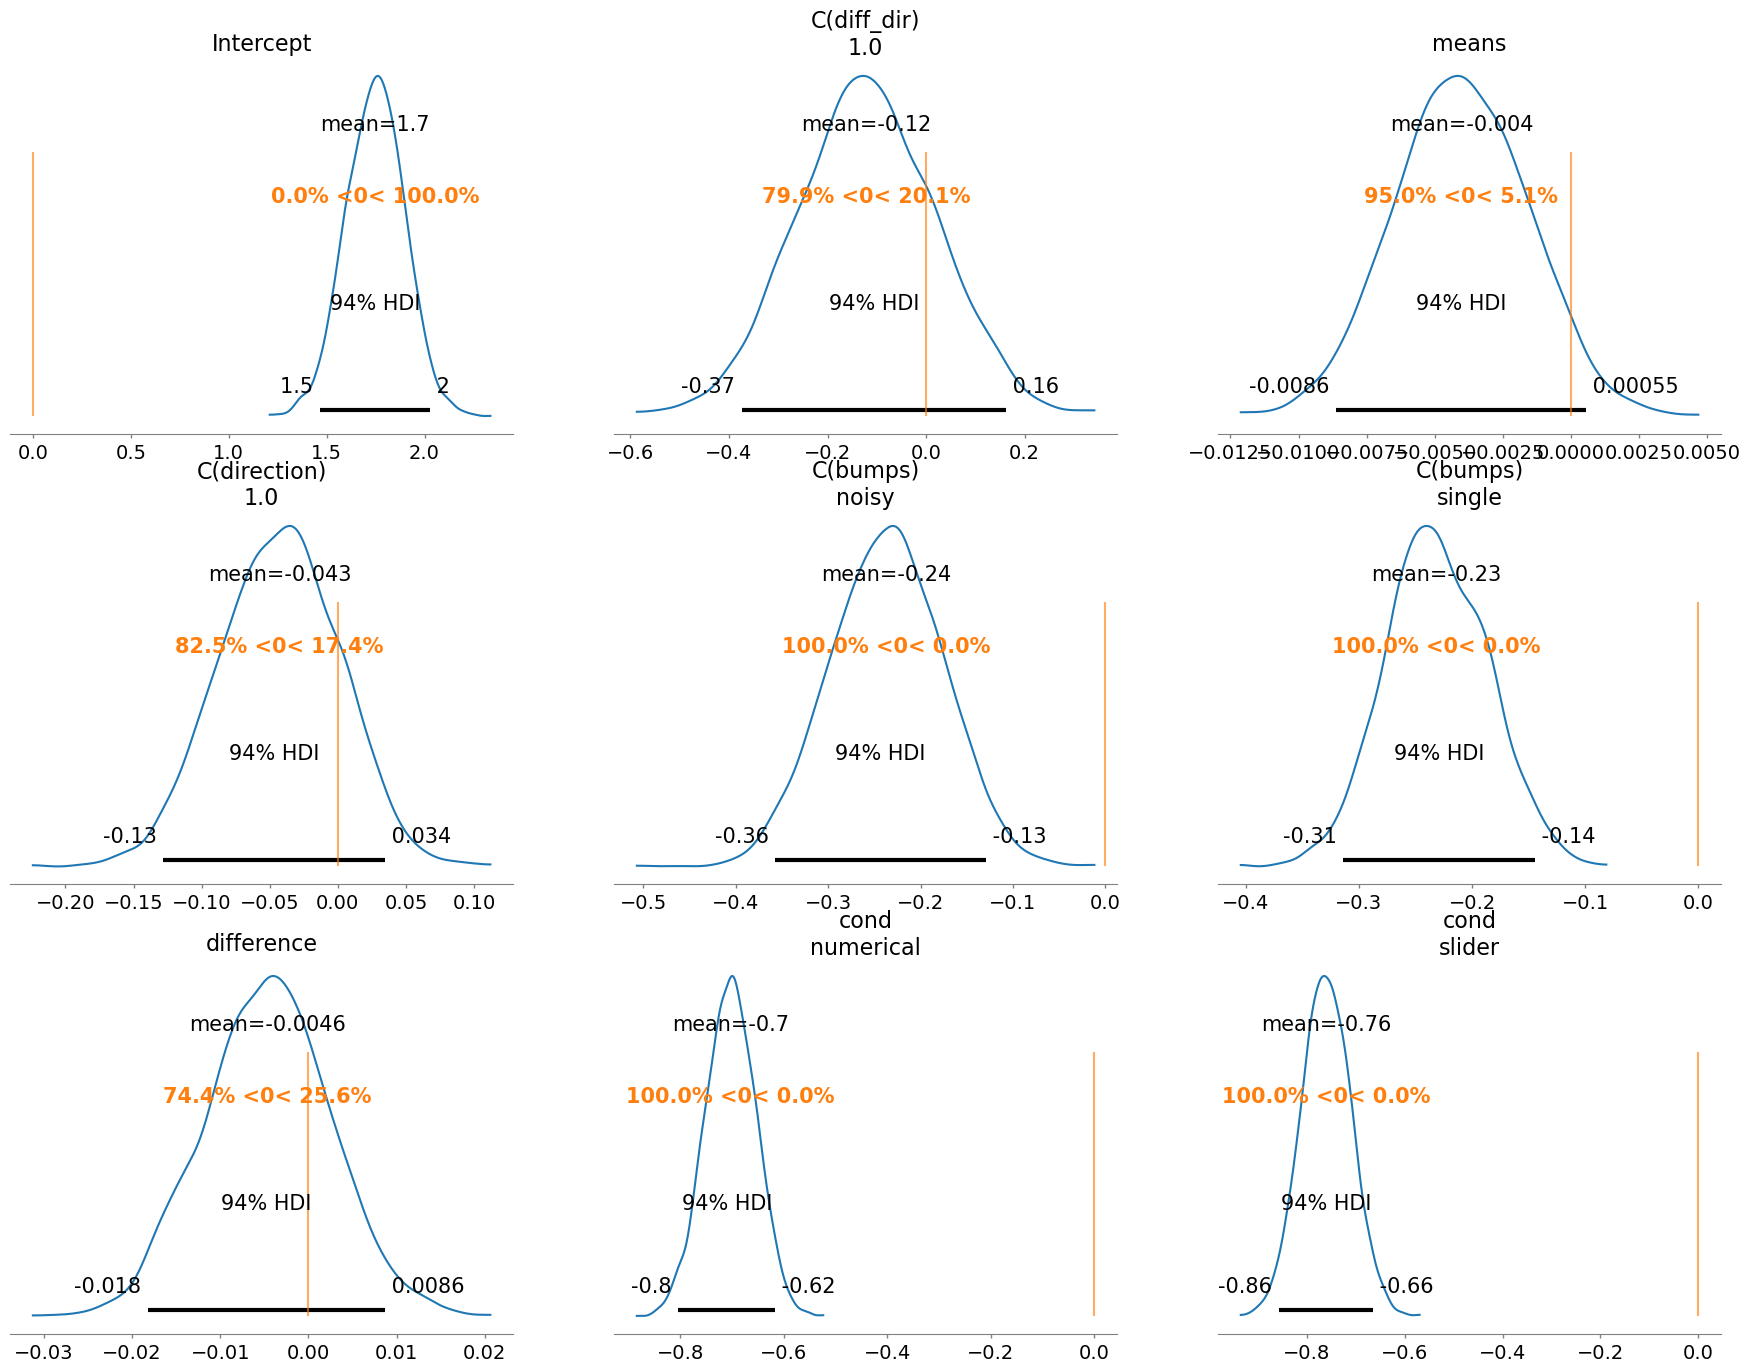

In [144]:
az.plot_posterior(allparam_nh_samples, ref_val=0)

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'diff_dir'}>,
        <Axes: title={'center': 'means'}>],
       [<Axes: title={'center': 'direction'}>,
        <Axes: title={'center': 'bumps\nnoisy'}>,
        <Axes: title={'center': 'bumps\nsingle'}>],
       [<Axes: title={'center': 'difference'}>,
        <Axes: title={'center': 'cond\nnumerical'}>,
        <Axes: title={'center': 'cond\nslider'}>]], dtype=object)

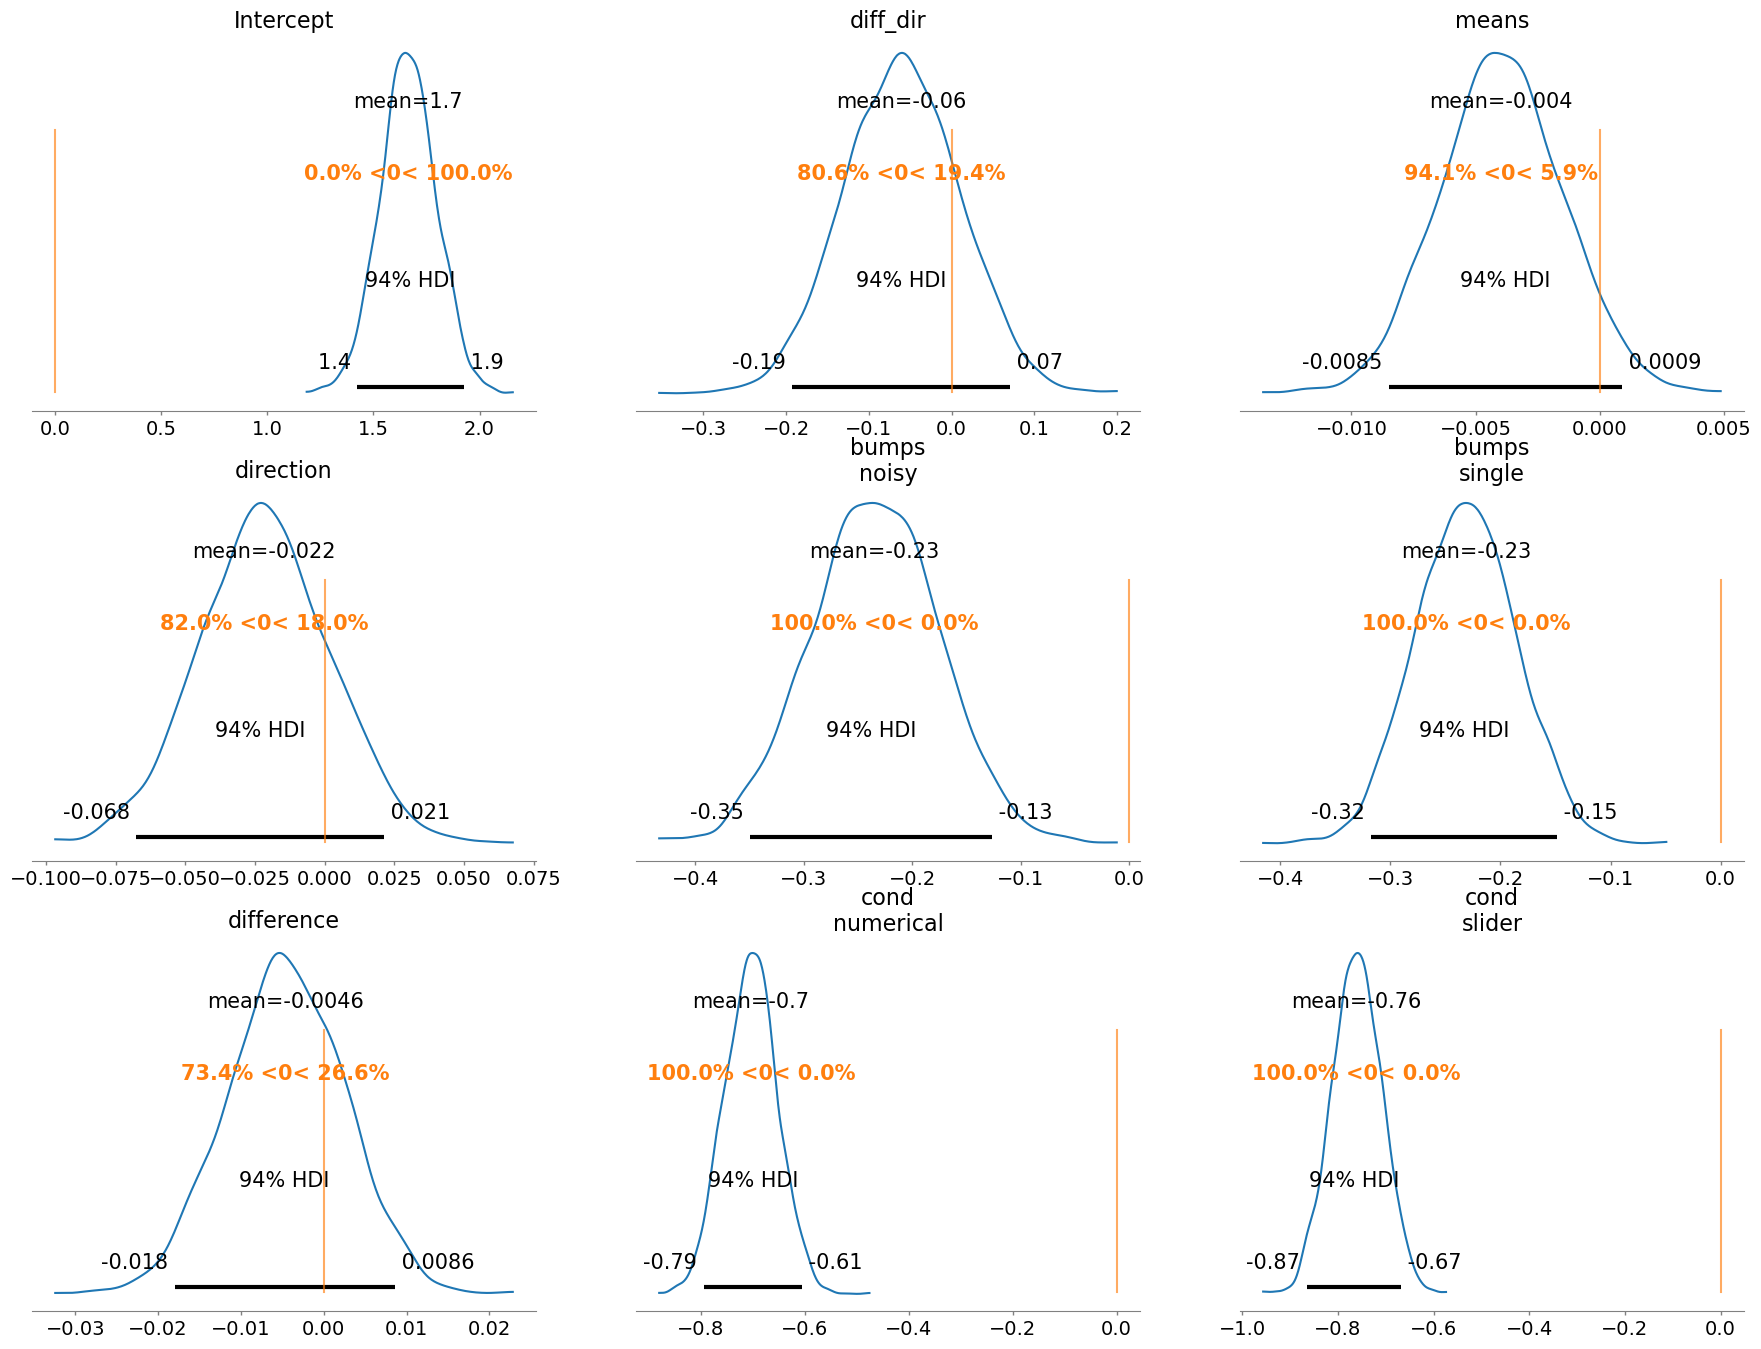

In [127]:
allparam_nh = bmb.Model('accuracy~ C(diff_dir) + means + C(direction) + C(bumps) + difference + cond', data = comb_data, family='bernoulli')
allparam_nh.build()
allparam_nh.graph()


In [103]:
hssm_model = hssm.HSSM(data=comb_data[['rt', 'response', 'means', 'direction', 'bumps', 'diff_dir', 'difference']], 
            include=
            [{"name": "v",
              "formula": "v ~ direction + bumps + diff_dir + difference"}])

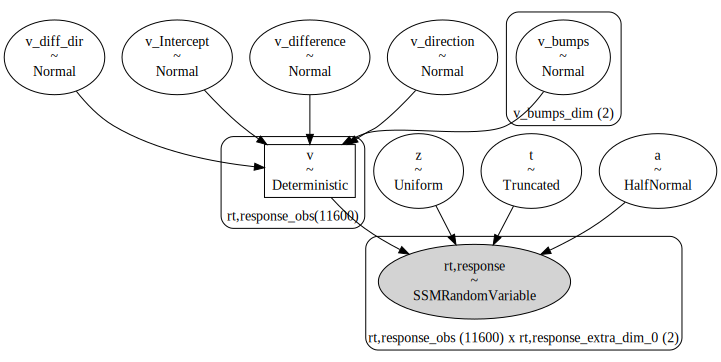

In [104]:
hssm_model.graph()

# Model Comparisons

In [147]:
model_comp_dict = model_single_param_samples
model_comp_dict['model_allparam_additive'] = allparam_nh_samples

In [148]:
az.compare(model_comp_dict)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_allparam_additive,0,-6912.400434,8.989560,0.000000,8.917299e-01,44.524490,0.000000,False,log
cond,1,-6937.288150,2.952795,24.887716,9.204281e-02,44.047450,7.875236,False,log
bumps,2,-7066.464272,3.019825,154.063838,1.622729e-02,42.240365,17.693935,False,log
diff_dir,3,-7068.850616,2.063937,156.450183,0.000000e+00,42.164904,17.536265,False,log
difference,4,-7068.997193,1.913157,156.596760,0.000000e+00,42.157769,17.576993,False,log
direction,5,-7079.427111,2.075945,167.026677,4.928491e-16,41.985301,18.262406,False,log
means,6,-7080.001670,2.046399,167.601236,0.000000e+00,41.962943,18.364374,False,log
